<img src="./pictures/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" /></a>


In [2]:
from math import sqrt, log10
import math

# Equations of sizing scenarios


The purpose of this notebook is to illustrate the main sizing equations on existing drone examples  . The selected drone are the [MK-Quadro](http://wiki.mikrokopter.de/MK-Quadro), the [Octocopter MK 8-3500](MK8-3500.pdf) [here](https://flydrotec.de/uav-systeme/mikrokopter/mk8-3500-flat-okto/mk8-3500-komplettsystem) drone, both of Mikrokopter, the [MG-1P](https://www.dji.com/fr/mg-1p/info#specs) and the [Spreading Wings S1000+](https://www.dji.com/fr/spreading-wings-s1000-plus/info#specs).

*Table of the main drones*  


MK-Quadro| Octocopter MK8 
- | - 
![MikroQuadro](./pics/MikroQuadro.jpg)|![mk8](./pics/mk8.jpg) 
**DJI MG-1P**| **Spreading Wings S1000+**
![mg1p](./pics/mg1p.jpg)| ![ehang](./pics/s1000+.png)

### Input data

It is essential to compare the results obtained from the sizing equations with different  drones. Here we are going to use different models:

Characteristics  | MK-Quadro  | MK-8 | DJI MG-1P | S1000+
-- | -- | --| -- |--
**Propellers** |**APC**
Diameter $D$ [m] |  0.254  | 0.406 | 0.5334|0.38
Pitch [M] |  0.11  |0.203 | 0.1779 |0.132
  | 
**Flight parameters**|
Total mass ready to take off [g] |1350  | 9152| 23800 |9500
Number of propellers |4 | 8|8  |8
  | 
**Motor model**|  **Roxxy 2827‐35**|**MK4008/350**|**DJI6010** |**HP4114 Pro 400KV**
Torque coefficient $K_{mot}$ [V/(rad/s)]| (1/760)*60/2/3.14 | (1/350)*60/2/3.14 | (1/130)*60/2/3.14 | (1/400)*60/2/3.14
Maximum current $I_{max}$ [A]|10A | 22A |40 A  |30 A
Continous current $I_{cont}$[A]|7.5 A|14 A|25 A|14 A
  | 
**Battery**|  **[LIPO 4S](https://www.amazon.fr/HRB-3300mAh-Batterie-h%C3%A9licopt%C3%A8re-Voiture/dp/B06XKWFPRZ/ref=sr_1_5/257-0018637-2563228?ie=UTF8&qid=1548771932&sr=8-5&keywords=Batterie+Lipo+4s)**| **[LIPO 6S](https://www.studiosport.fr/batterie-lipo-6s-4500-mah-25c-xt60-tattu-p-5068.html?gclid=Cj0KCQiAkMDiBRDNARIsACKP1FFV6TXhQ12d4UhtBpb5NuAmjF0Oo_b7qrGHuh2YSK1mnsHDeCqPtQUaAn-_EALw_wcB)**|**[MG-12000P](https://dl.djicdn.com/downloads/mg_1p/20180705/MG-12000P+Flight+Battery+User+Guide_Multi.pdf)**|**TATTU 6S 15C Lipo**
Voltage [V]|(4*3.7) | (6*3.7)    | 44.4 |(6*3.7)
Capacity [mAh] | 3300| 4500*6   | 12000  |16000
Mass [g]| 329 |  745   | 4000  |1932

### Algorithm of validation


In [3]:
def validation (D,pitch,Mass_total,N_prop,V_bat,I_max, I_cont, Kt, C,R, Mfmot_ref, Mmot_ref,prop ):

    rho=1.18 #[kg/m3] Air volume density

    # PROPELLERS-----------
    #From APC distribution
    
    beta=pitch/D
    
    if prop=='APC-MR':
        
        C_t=4.1938e-02 + 1.4578e-01 * beta # Thrust coef with T=C_T.rho.n^2.D^4
    
        C_p=7.97e-04 + 9.0482e-02 * beta  # Power coef with P=C_p.rho.n^3.D^5
    
    elif prop=='Graupner':
        
        C_p=0.0922* beta - 0.0094 # Thrust coef with T=C_T.rho.n^2.D^4
    
        C_t=0.1755*beta - 0.0008  # Power coef with P=C_p.rho.n^3.D^5
        
    elif prop=='GWS':

        C_p=0.1011*beta - 0.0062
    
        C_t=0.1163*beta + 0.0527
        
    elif prop=='APC-E':
        C_p=-1.13e-02 +1.06e-01 *beta

        C_t= 4.92e-02 +1.00e-01 *beta

    elif prop=='APC-C':
        C_p=-3.47e-03 +8.26e-02 *beta
        
        C_t=4.47e-02 +8.86e-02 *beta

    #HOVER SCENARIO--------
    
    T_hover=Mass_total*9.81/N_prop # [N] Thrust per propeller at hover

    n_hover=sqrt(T_hover/(C_t*rho*D**4)) #[Hz] rotational speed at hover
    
    P_hover=C_p*rho*n_hover**3*D**5 #[W] Power per propeller     
    
    W_hover=n_hover*2*3.14 #[rad/s] rotational speed at hover

    M_prop_hover=P_hover/W_hover # [N.m] Propeller torque at hover
    
    Mfmot=Mfmot_ref*(M_prop_hover/Mmot_ref)**(3/3.5) # [N.m] Friction torque
    
    Mmot=M_prop_hover+Mfmot # [N.m] Total torque
    
    #MOTOR PARAMETERS HOVER------
    
    I_hover=Mmot/Kt  #[A] motor current per propeller
    
    U_hover=R*I_hover+Kt*W_hover #[V] motor voltage per propeller at hover
    
    P_el_hover=I_hover*U_hover/0.9 #[W] Power efficiency at hover 90% ESC
        
    #BATTERY PARANETERS HOVER-----
    
    I_bat= U_hover*I_hover*N_prop/(0.9*V_bat) #[A] battery current assuming 95% efficiency for ESC
    
    t_hov=C/I_bat*60 #[min] autonomy of battery flying at hover wth 100% depth of discharge

    #TAKE-OFF PARAMETERS---------
    W_max=(V_bat-R*I_max)/Kt #[rad/s] maximum rotational speed at take-off
    
    T_to=C_t*rho*W_max**2*D**4/(4*3.14**2)#[N] maximum propeller thrust
    
    P_to=C_p*rho*W_max**3*D**5/(8*3.14**3)#[W] maximum propeller power 
    
    M_prop_to=P_to/W_max  # [N.m] Propeller torque at TO
    
    M_to=M_prop_to+Mfmot # [N.m] Total torque at TO adding frictions
    
    I_to=M_to/Kt # [A] motor current at TO
    
    U_to=R*I_to+Kt*W_max #[V] motor voltage per propeller at TO
    
    P_el_TO=U_to*I_to/0.9 #[W] Power efficiency 90% ESC
        
    a_max=T_to*N_prop/Mass_total #[m/s^2] maximum acceleration
    
    return P_el_TO,t_hov,a_max,P_el_hover

In [4]:
final=[]
#Diameter
D_mk4= 0.254 #[m]
D_mk8= 0.406 #[m]
D_dji= 0.5334 #[m]
D_s1000= 0.38 #[m]

D=[D_mk4,D_mk8,D_dji,D_s1000]

#Pitch
p_mk4= 0.11# [m] 
p_mk8= 0.203 #[m] 
p_dji=0.1778 #[m] 
p_s1000=0.132 #[m] 

p=[p_mk4,p_mk8,p_dji,p_s1000]

#Mass
M_mk4=1.35 # [kg] 
M_mk8=5.652+ 0.745 + 0.3 # [kg] base weight + battery (https://hobbyking.com/en_us/turnigy-battery-4500mah-6s-30c-lipo-pack-xt-90.html) + gimbal (https://www.mikrocontroller.com/index.php?main_page=product_info&products_id=598&language=en)
M_dji=24.8 # [kg] 
M_s1000=9.5 # [kg]

M=[M_mk4,M_mk8,M_dji,M_s1000]

# [-] propeller number
N_mk4=4 
N_mk8=8 
N_dji=8 
N_s1000=8 

N=[N_mk4,N_mk8,N_dji,N_s1000]

# Max Current
I_max_mk4=10 #[A] 
I_max_mk8=22 #[A] 
I_max_dji=40 #[A] 
I_max_s1000= 30 #[A] 

I_max=[I_max_mk4,I_max_mk8,I_max_dji,I_max_s1000]


#Voltage battery
V_bat_mk4=4*3.7 #[V] 
V_bat_mk8=6*3.7 #[V] 
V_bat_dji=12*3.7 #[V]
V_bat_s1000=6*3.7 #[V] 

V=[V_bat_mk4,V_bat_mk8,V_bat_dji,V_bat_s1000]

#Motor torque coefficient

K_mk4=(1/760)*60/2/3.14 # [V/(rad/s)] 
K_mk8=(1/350)*60/2/3.14 # [V/(rad/s)]  
K_dji=(1/130)*60/2/3.14 # [V/(rad/s)] 
K_s1000=(1/400)*60/2/3.14 # [V/(rad/s)] 

K=[K_mk4,K_mk8,K_dji,K_s1000]

#Capacity battery

C_mk4=3.3 #[A.h] 
C_mk8=4.5*6 #[A.h] 
C_dji=12 #[A.h] 
C_s1000=16 #[A.h] 

C=[C_mk4,C_mk8,C_dji,C_s1000]

#Continuous current
I_cont_mk4=7.5 #[A] 
I_cont_mk8=14 #[A] 
I_cont_dji=25 #[A] 
I_cont_s1000=14 #[A]

I=[I_cont_mk4,I_cont_mk8,I_cont_dji,I_cont_s1000]

#Reference values
rho=1.18 #[kg/m3] Air volume density
Mmot_ref=2.32  # [N.m] rated torque
Rmot_ref=0.03  # [Ohm] resistance
Ktmot_ref=0.03 # [N.m/A] torque coefficient
Mfmot_ref=0.03 # [N.m] friction torque (zero load, nominal speed) 


#resistance

R_dji=0.23 #[ohm] resistance dji (https://www.adorama.com/djicpep00088.html)
R_s1000=0.172 #[ohm] resistance s1000 (https://hobbyking.com/en_us/4112-400kv-turnigy-multistar-22-pole-brushless-multi-rotor-motor-with-extra-long-leads.html?___store=en_us)
R_mk8=0.4 # (supposed)

M_moy_mk4=K_mk4*I_cont_mk4 #[N.m] Motor nominal torque per propeller     
R_mk4=Rmot_ref*(M_moy_mk4/Mmot_ref)**(-5/3.5)*(K_mk4/Ktmot_ref)**(2)  # [Ohm] motor resistance

R=[R_mk4,R_mk8,R_dji,R_s1000]

#Propeller Type:

Prop=['Graupner','Graupner','Graupner','Graupner']

for  A,B,C,D,E,F,G,H,I,J,K in zip(D,p,M,N,V,I_max,I,K,C,R,Prop):
    final.append(validation(A,B,C,D,E,F,G,H,I,J, Mfmot_ref, Mmot_ref,K))
    


### Output features 

Characteristics  | MK4 | MK-8  | DJI MG-1P | S1000+ 
-- | -- | --| -- |--
**P_max per propeller (W)**
- calculated|{{math.ceil(final[0][0])}}|{{math.ceil(final[1][0])}}|{{math.ceil(final[2][0])}}|{{math.ceil(final[3][0])}}
- catalog|{{440/4}}|{{2800/8}}|{{6400/8}}|{{4000/8}}
- percentage deviation (%)| {{math.ceil(100*((440/4)-final[0][0])/(440/4))}}|{{math.ceil(100*((2800/8)-final[1][0])/(2800/8))}}|{{math.ceil(100*((6400/8)-final[2][0])/(6400/8))}}|{{math.ceil(100*(4000/8-final[3][0])/(4000/8))}}
**P_hover per propeller(W)**
- calculated|{{math.ceil(final[0][3])}}|{{math.ceil(final[1][3])}}|{{math.ceil(final[2][3])}}|{{math.ceil(final[3][3])}}
- catalog|-|-|{{3800/8}}|{{1500/8}}
- percentage deviation (%) |-|-|{{math.ceil(100*((3800/8)-final[2][3])/(3800/8))}}|{{math.ceil(100*((1500/8)-final[3][3])/(1500/8))}}|
**t_hover(min)**
- calculated|{{round(final[0][1],2)}}|{{round(final[1][1],2)}}|{{round(final[2][1], 2)}}|{{round(final[3][1],2)}}
- catalog|-|40|9|15
- percentage deviation (%)| - |{{(math.ceil(100*(-40+final[1][1])/40))}}|{{math.ceil(100*(9-final[2][1])/9)}}|{{math.ceil(100*(-15+final[3][1])/(15))}}




The power for the drone provided by the manufacturer is divided by N propellers. 



**High deviations in P_hover. Possible reasons:**
- Which kind of propellers follow such models?
- An efficiency of 95% was supposed to the motor. Higher losses causes a drop of the efficiency? Maybe a lower efficiency is applied here, supposing cable , electronic and other losses.

**Deviations in P_max. Possible reasons:**
- Internal resistance are unknown in some cases(MK4 and MK8) that is why deviations of maximum power may occcur.
- Cp and Ct follow a regression for MR-Multirotor. Which kind of propellers follow such models?

**Dynamic Markdown. How to do it ?** 

Through the use of a dynamic Markdown , the values can be read. To get this, you need to install in your terminal the following packages: `pip install jupyter_contrib_nbextensions`, then `jupyter contrib nbextension install --user` and finally, `jupyter nbextension enable python-markdown/main`. After the above commands, you can restart your Jupyter Notebook and call the values with double keys: {{value}} in the Markdown cell.

## Dependance graph for the determination of power and autonomy of the battery

It is important to know the relationships between each variable to assess the influence that have each one in the final result. In the next maps, we see the effect of some input parameters in the power and autonomy of the battery.

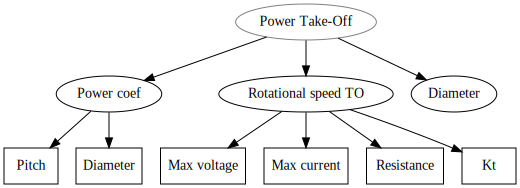

In [6]:
# Plot the WBS of the system
from graphviz import Digraph

dot = Digraph(comment='Power TO')
# System
dot.node('S', 'Power Take-Off', color='grey')
# Components
dot.node('C1', 'Power coef')
dot.node('C2', 'Rotational speed TO')
dot.node('C3', 'Diameter')

dot.node('CC1','Pitch',shape='rectangle')
dot.node('CC2','Diameter',shape='rectangle')
dot.node('CC3','Max voltage',shape='rectangle')
dot.node('CC4','Max current',shape='rectangle')
dot.node('CC5','Resistance',shape='rectangle')
dot.node('CC6','Kt',shape='rectangle')

#Links
dot.edge('C1','CC1')
dot.edge('C1','CC2')
dot.edge('C2','CC3')
dot.edge('C2','CC4')
dot.edge('C2','CC5')
dot.edge('C2','CC6')

dot.edge('S','C1')
dot.edge('S','C2')
dot.edge('S','C3')

# Render the graph into the notebook
dot



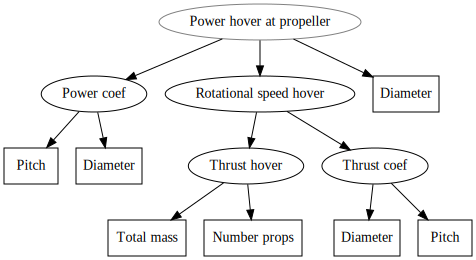

In [7]:
# Plot the WBS of the system
from graphviz import Digraph

HOV = Digraph(comment='Power hover')
# System
HOV.node('A', 'Power hover at propeller', color='grey')
# Components
HOV.node('A1', 'Power coef')
HOV.node('A2', 'Rotational speed hover')
HOV.node('A3', 'Diameter',shape='rectangle')



HOV.node('AA1','Pitch',shape='rectangle')
HOV.node('AA2','Diameter',shape='rectangle')

HOV.node('AA3','Thrust hover')
HOV.node('AA4','Thrust coef')

HOV.node('AAA1','Total mass',shape='rectangle')
HOV.node('AAA2','Number props',shape='rectangle')
HOV.node('AAA3','Diameter',shape='rectangle')
HOV.node('AAA4','Pitch',shape='rectangle')

#Links
HOV.edge('A2','AA3')
HOV.edge('A2','AA4')

HOV.edge('A1','AA1')
HOV.edge('A1','AA2')


HOV.edge('AA3','AAA1')
HOV.edge('AA3','AAA2')
HOV.edge('AA4','AAA3')
HOV.edge('AA4','AAA4')

HOV.edge('A','A1')
HOV.edge('A','A2')
HOV.edge('A','A3')

# Render the graph into the notebook
HOV


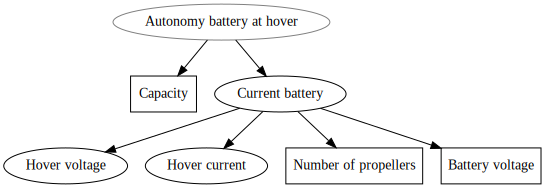

In [8]:
HOV = Digraph(comment='Autonomy battery')
# System
HOV.node('A', 'Autonomy battery at hover', color='grey')
# Components
HOV.node('A1', 'Capacity',shape='rectangle')
HOV.node('A2', 'Current battery')

HOV.node('AA1','Hover voltage')
HOV.node('AA2','Hover current')
HOV.node('AA3','Number of propellers',shape='rectangle')
HOV.node('AA4','Battery voltage',shape='rectangle')

#Links
HOV.edge('A','A1')
HOV.edge('A','A2')
HOV.edge('A2','AA1')
HOV.edge('A2','AA2')
HOV.edge('A2','AA3')
HOV.edge('A2','AA4')



# Render the graph into the notebook
HOV
